# **Capitulo 5 – Decision Trees**

Los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [68]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y creemos la carpeta `images/decision_trees` (si no existe ya), y definamos la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [69]:
from pathlib import Path
# Esta es otra forma de crear directorios 
# IMAGES_PATH es un objeto que permite hacer llamadas al sistema
# como por ejemplo, crear un directorio
IMAGES_PATH = Path() / "images" / "decision_trees"
# parents: crear directorios superiores o no
# exist_ok: qué pasa si ya existe
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Los árboles de decisión son algoritmos versátiles de Machine Learning que pueden realizar tanto tareas de clasificación como de regresión. 
Son algoritmos potentes, capaces de ajustar conjuntos de datos complejos. También sirven de base para otros algoritmos, como randomforest o xgboost.

En este Notebook empezaremos por discutir cómo entrenar, visualizar y hacer predicciones con árboles de decisión. 

A continuación, repasaremos el algoritmo de entrenamiento CART utilizado por Scikit-Learn, y exploraremos cómo regularizar árboles y utilizarlos para tareas de regresión. Por último, discutiremos algunas de las limitaciones de los árboles de decisión.

# Training and Visualizing a Decision Tree

Para entender los árboles de decisión, construyamos uno y veamos cómo realiza predicciones. El siguiente código entrena un DecisionTreeClassifier en el conjunto de datos del iris:

In [70]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
# examinar dataset iris: info, describe, columnas

In [155]:
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]]
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=1)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

Puede visualizar el árbol de decisión entrenado utilizando primero la función export_graphviz() para generar un archivo de definición de gráficos llamado iris_tree.dot:

In [156]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

A continuación, puede utilizar graphviz.Source.from_file() para cargar y mostrar el archivo en un NoteBook:

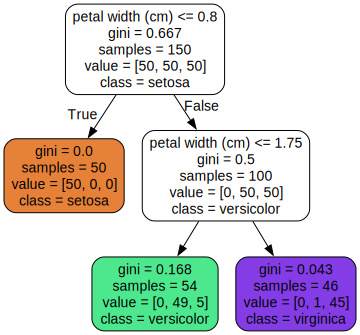

In [157]:
# graphviz no esta. Os acordáis como instalar paquetes?
# y que era requirements.txt?
# Repaso de pip
# Desgcargar, AÑADIR AL PATH, reiniciar si hace falta.
# https://graphviz.org/download/
from graphviz import Source

Source.from_file("images/decision_trees/iris_tree.dot")

In [74]:
# ANalizar hojas, chequear resultados, comprobar
dt = X_iris

In [75]:
dt["target"] = y_iris

C:\Users\pabma\AppData\Local\Temp\ipykernel_26648\19329559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt["target"] = y_iris


In [124]:
dt["labels"] = dt["target"].map({0:"setosa", 1:"versicolor", 2:"virginica"})

In [133]:
setosa = dt[dt['petal length (cm)'] <= 2.45].groupby("labels").count()
setosa

,petal length (cm),petal width (cm),target
labels,,,
setosa,50,50,50


In [132]:
versicolor = dt[(dt['petal length (cm)'] > 2.45)&(dt['petal width (cm)'] <= 1.75)].groupby("labels").count()
versicolor

,petal length (cm),petal width (cm),target
labels,,,
versicolor,49,49,49
virginica,5,5,5


In [159]:
virginica = dt[(dt['petal length (cm)'] >= 2.45)&(dt['petal width (cm)'] > 1.75)].groupby("labels").count()
virginica.value_counts()

petal length (cm)  petal width (cm)  target
1                  1                 1         1
45                 45                45        1
Name: count, dtype: int64

Graphviz también proporciona la herramienta de línea de comandos `dot` para convertir archivos `.dot` a una variedad de formatos. El siguiente comando convierte el archivo dot en una imagen png:

In [135]:
!dot -Tpng {IMAGES_PATH / "iris_tree.dot"} -o {IMAGES_PATH / "iris_tree.png"}

# Making Predictions

Veamos cómo hace predicciones el árbol representado en la Figura anterior. Supongamos que encuentra una flor de iris y quiere clasificarla en función de sus pétalos. Se empieza por el nodo raíz (profundidad 0, en la parte superior): este nodo pregunta si la longitud de los pétalos de la flor es inferior a 2,45 cm. En caso afirmativo, se desciende hasta el nodo hijo izquierdo de la raíz (profundidad 1, izquierda). En este caso, es un nodo hoja (es decir, no tiene ningún nodo hijo), por lo que no hace ninguna pregunta: simplemente mire la clase predicha para ese nodo, y el árbol de decisión predice que su flor es una Iris setosa (class=setosa).

Supongamos ahora que encuentra otra flor, y esta vez la longitud del pétalo es superior a 2,45 cm. De nuevo empieza en la raíz, pero ahora desciende hasta su nodo hijo derecho (profundidad 1, derecha). Este no es un nodo hoja, es un nodo partido, por lo que hace otra pregunta: ¿la anchura del pétalo es menor de 1,75 cm? Si es así, lo más probable es que su flor sea un Iris versicolor (profundidad 2, izquierda). En caso contrario, es probable que se trate de un Iris virginica (profundidad 2, derecha). Así de sencillo.

Una de las muchas cualidades de los árboles de decisión es que requieren muy poca preparación de los datos. De hecho, no requieren escalado o centrado de características en absoluto.

El atributo muestras de un nodo cuenta a cuántas instancias de entrenamiento se aplica. Por ejemplo, 100 instancias de entrenamiento tienen una longitud de pétalo superior a 2,45 cm (profundidad 1, derecha), y de esas 100, 54 tienen una anchura de pétalo inferior a 1,75 cm (profundidad 2, izquierda). El atributo de valor de un nodo indica a cuántos casos de entrenamiento de cada clase se aplica este nodo: por ejemplo, el nodo inferior derecho se aplica a 0 Iris setosa, 1 Iris versicolor y 45 Iris virginica.

 Por último, el atributo gini de un nodo mide su impureza de Gini: un nodo es "puro" (gini=0) si todas las instancias de entrenamiento a las que se aplica pertenecen a la misma clase. Por ejemplo, como el nodo izquierdo de profundidad 1 sólo se aplica a las instancias de entrenamiento de Iris setosa, es puro y su impureza de Gini es 0. La ecuación muestra cómo el algoritmo de entrenamiento calcula la impureza de Gini $G_i$ del nodo $i^ésimo$. El nodo izquierdo de profundidad 2 tiene una impureza de Gini igual a $1 - (0/54)^2 - (49/54)^2 - (5/54)^2 ≈ 0,168$.

$$G_i = 1 - \sum_{k=1}^n P_i,k^2$$

En esta ecuación
- $G_i$ es la impureza de Gini del nodo $i-ésimo$.
- $P_i,k$ es la proporción de instancias de clase k entre las instancias de entrenamiento en el nodo $i^ésimo$.



In [158]:
# Replicar en código el GINI
for x in range(51):
    G = 1 - (x/50)**2 - ((50-x)/50)**2
    print(x, 50-x, G)

0 50 0.0
1 49 0.039200000000000124
2 48 0.07679999999999998
3 47 0.11280000000000001
4 46 0.1472
5 45 0.17999999999999994
6 44 0.21120000000000005
7 43 0.24080000000000013
8 42 0.26880000000000015
9 41 0.29520000000000013
10 40 0.31999999999999984
11 39 0.34319999999999995
12 38 0.3648
13 37 0.38480000000000003
14 36 0.4032
15 35 0.4200000000000001
16 34 0.43519999999999986
17 33 0.4487999999999999
18 32 0.46080000000000004
19 31 0.4712
20 30 0.48
21 29 0.4872
22 28 0.49279999999999996
23 27 0.49679999999999996
24 26 0.49920000000000003
25 25 0.5
26 24 0.49920000000000003
27 23 0.4967999999999999
28 22 0.4927999999999999
29 21 0.48719999999999997
30 20 0.48
31 19 0.47119999999999995
32 18 0.46080000000000004
33 17 0.4488
34 16 0.43519999999999986
35 15 0.42000000000000004
36 14 0.4032
37 13 0.38480000000000003
38 12 0.3648
39 11 0.34319999999999995
40 10 0.31999999999999984
41 9 0.29520000000000013
42 8 0.2688000000000001
43 7 0.24080000000000007
44 6 0.21120000000000003
45 5 0.1799999

In [161]:
Gini1 = 1 - (50/150)**2 - (50/150)**2 - (50/150)**2
Gini2 = 1 - (50/50)**2 - (0/50)**2 - (0/50)**2
Gini3 = 1 - (50/100)**2 - (50/100)**2 - (0/100)**2
Gini4 = 1 - (49/54)**2 - (5/54)**2 - (0/54)**2
Gini5 = 1 - (0/46)**2 - (1/46)**2 - (45/46)**2
ginis = [Gini1, Gini2, Gini3, Gini4, Gini5]

for i in ginis:
    print(i)

0.6666666666666665
0.0
0.5
0.1680384087791495
0.04253308128544431


In [162]:
accuraccy = 1 - 6/150
accuraccy

0.96

Scikit-Learn utiliza el algoritmo ``CART``, que sólo produce árboles binarios, es decir, árboles en los que los nodos divididos siempre tienen exactamente dos hijos (es decir, las preguntas sólo tienen respuestas sí/no). Sin embargo, otros algoritmos, como ID3, pueden producir árboles de decisión con nodos que tienen más de dos hijos.

c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


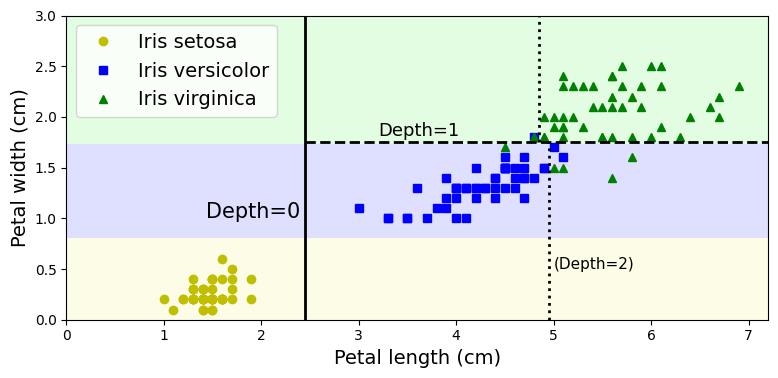

In [164]:
# De esto, lo que hay que entender es el gráfico, NO EL CÓDIGO

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))
lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))

X_iris = iris.data[['petal length (cm)','petal width (cm)']].values
y_iris = iris.target
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_decision_boundaries_plot")

plt.show()

La figura muestra los límites de decisión de este árbol de decisión. La línea vertical gruesa representa el límite de decisión del nodo raíz (profundidad 0): longitud del pétalo = 2,45 cm. 

Como la zona izquierda es pura (sólo Iris setosa), no puede dividirse más. 

Sin embargo, la zona derecha es impura, por lo que el nodo derecho de profundidad 1 la divide a una anchura de pétalo = 1,75 cm (representada por la línea discontinua). 

Como profundidad_máxima se ha establecido en 2, el árbol de decisión se detiene justo ahí. 

Si fijara profundidad_máxima en 3, entonces los dos nodos de profundidad-2 añadirían cada uno otro límite de decisión (representado por las dos líneas punteadas verticales).

In [80]:
export_graphviz(
        tree_clf_deeper,
        out_file=str(IMAGES_PATH / "iris_tree_deep_2.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

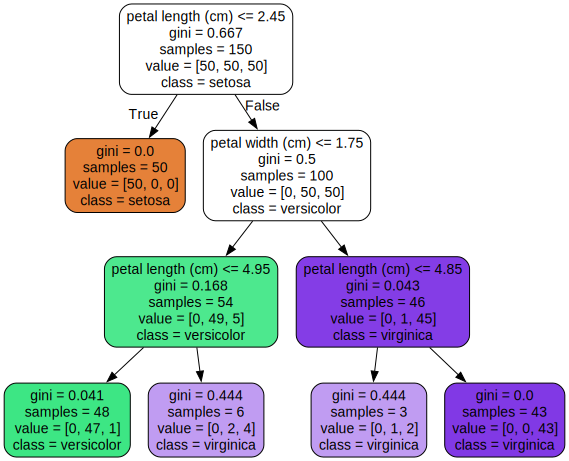

In [81]:
Source.from_file("images/decision_trees/iris_tree_deep_2.dot")

In [165]:
versicolor = dt[(dt['petal length (cm)'] > 2.45)&(dt['petal width (cm)'] <= 1.75)&(dt['petal length (cm)'] <= 4.95)].groupby("labels").count()
versicolor

,petal length (cm),petal width (cm),target
labels,,,
versicolor,47,47,47
virginica,1,1,1


In [167]:
virginica = dt[(dt['petal length (cm)'] > 2.45)&(dt['petal width (cm)'] > 1.75)|(dt['petal length (cm)'] > 4.95)].groupby("labels").count()
virginica

,petal length (cm),petal width (cm),target
labels,,,
versicolor,3,3,3
virginica,49,49,49


In [173]:
g2 = (0*50 + 54*0.168 + 46*0.043)/150
g3 = (0.041*48 + 0.444*6 + 0.444*3 + 0*43 + 0*50)/150
print(g2, g3)

0.07366666666666667 0.03976


In [82]:
# Interpretar
# Comprobar
# Calcular gini
1-(1+2+1)/150
# Un gini superior al 50%???
g2 = (0*50 + 54*0.168 + 46*0.043)/150
g2

0.07366666666666667

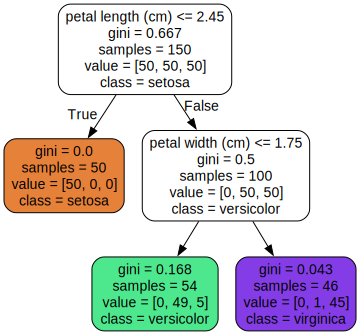

In [83]:
# Compara modelos. ¿Qué métrica usamos?
Source.from_file("images/decision_trees/iris_tree.dot")

In [176]:
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]]
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42, min_samples_leaf=6)
tree_clf.fit(X_iris, y_iris)
export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree_deep_3_min_leaf.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

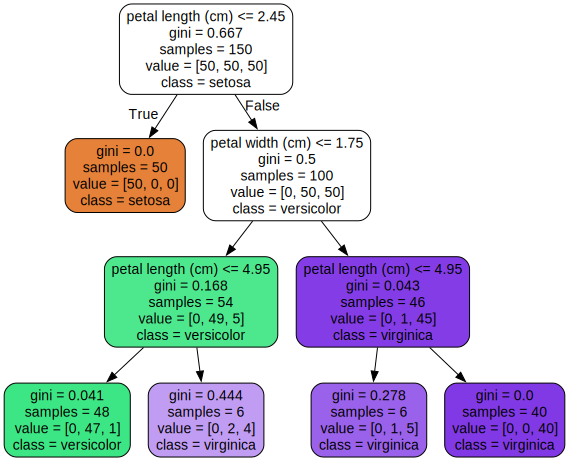

In [177]:
Source.from_file("images/decision_trees/iris_tree_deep_3_min_leaf.dot")

La estructura del árbol, incluyendo toda la información mostrada en la Figura, está disponible a través del atributo tree_ del clasificador. Escriba help(tree_clf.tree_) para más detalles.


Puede acceder a la estructura de árbol mediante el atributo `tree_`:

In [84]:
tree_clf.tree_.impurity

In [88]:
tree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1,
 'splitter': 'best'}

In [85]:
# help(sklearn.tree._tree.Tree)

## Interpretación de modelos: Caja blanca frente a caja negra

Los árboles de decisión son intuitivos y sus decisiones son fáciles de interpretar. Estos modelos suelen denominarse modelos de caja blanca. 

Por el contrario, como verá, los RandomForest y las redes neuronales suelen considerarse modelos de caja negra: hacen [muy] (buenas) predicciones, y se pueden comprobar fácilmente los cálculos que realizaron para hacer estas predicciones; sin embargo, suele ser difícil explicar en términos sencillos por qué se hicieron las predicciones. 

Por ejemplo, si una red neuronal dice que una persona concreta aparece en una foto, es difícil saber qué contribuyó a esta predicción: ¿Reconoció el modelo los ojos de esa persona? ¿la boca? ¿la nariz? ¿Sus zapatos? ¿O incluso el sofá en el que estaba sentada? 

Por el contrario, los árboles de decisión proporcionan reglas de clasificación sencillas y agradables que incluso pueden aplicarse manualmente si es necesario (por ejemplo, para la clasificación de flores). 

El campo del ML interpretable tiene como objetivo crear sistemas de ML que puedan explicar sus decisiones de forma comprensible para los humanos. Esto es importante en muchos ámbitos, por ejemplo, para garantizar que el sistema no tome decisiones injustas.

In [86]:
# En concreto, podemos "simular" un árbol de desición jugando a ser Dios, es decir, 
# usando secuencias de if-elif-else anidados

# Estimating Class Probabilities

Un árbol de decisión también puede estimar la probabilidad de que una instancia pertenezca a una determinada clase k. En primer lugar, recorre el árbol para encontrar el nodo hoja de esta instancia y, a continuación, devuelve la proporción de instancias de entrenamiento de la clase k en este nodo. 

Por ejemplo, supongamos que ha encontrado una flor cuyos pétalos miden 5 cm de largo y 1,5 cm de ancho. El nodo de hoja correspondiente es el nodo izquierdo de profundidad 2, por lo que el árbol de decisión arroja las siguientes probabilidades: 0% para Iris setosa (0/54), 90,7% para Iris versicolor (49/54) y 9,3% para Iris virginica (5/54). Y si se le pide que prediga la clase, da como resultado Iris versicolor (clase 1) porque tiene la probabilidad más alta. Vamos a comprobarlo:

In [87]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([[0.   , 0.907, 0.093]])

In [88]:
tree_clf.predict([[5, 1.5]])

c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1])

In [175]:
tree_clf.tree_.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

¡Perfecto! Observe que las probabilidades estimadas serían idénticas en cualquier otro lugar del rectángulo inferior derecho de la Figura, por ejemplo, si los pétalos midieran 6 cm de largo y 1,5 cm de ancho (aunque parece obvio que en este caso lo más probable es que se trate de un Iris virginica).

## El algoritmo de entrenamiento CART

Scikit-Learn utiliza el algoritmo CART (Classification and Regression Tree) para entrenar árboles de decisión (también llamados árboles "crecientes"). El algoritmo funciona dividiendo primero el conjunto de entrenamiento en dos subconjuntos utilizando una única característica k y un umbral tk (por ejemplo, "longitud de los pétalos ≤ 2,45 cm"). ¿Cómo elige k y tk? Busca el par (k, tk ) que produce los subconjuntos más puros, ponderados por su tamaño. La ecuación da la función de coste que el algoritmo intenta minimizar.

$$
J(k, t_k) = \frac{m_{\text{left}}}{m} G_{\text{left}} + \frac{m_{\text{right}}}{m} G_{\text{right}}
$$

Donde:

- $ J(k, t_k) $ es la función de costo basada en una determinada división del conjunto de datos.
- $ k $ y $ t_k $ representan el umbral y la característica utilizada para la división.
- $ G_{\text{left/right}} $ mide la impureza del subconjunto izquierdo/derecho.
- $ m_{\text{left/right}} $ es el número de instancias en el subconjunto izquierdo/derecho.
- $ m $ es el número total de instancias.

Una vez que el algoritmo CART ha dividido con éxito el conjunto de entrenamiento en dos, divide los subconjuntos utilizando la misma lógica, luego los subsubconjuntos, y así sucesivamente, de forma recursiva. El algoritmo deja de recursar cuando alcanza la profundidad máxima (definida por el hiperparámetro max_depth) o si no puede encontrar una división que reduzca la impureza. Otros hiperparámetros (que se describirán más adelante) controlan otras condiciones de parada: min_samples_split, min_samples_leaf, min_weight_fraction_leaf y max_leaf_nodes.

Como puede ver, el algoritmo CART es un algoritmo codicioso: busca codiciosamente una división óptima en el nivel superior y luego repite el proceso en cada nivel posterior. No comprueba si la división conducirá o no a la menor impureza posible varios niveles más abajo. Un algoritmo codicioso suele producir una solución razonablemente buena, pero no garantiza que sea la óptima. Por desgracia, se sabe que encontrar el árbol óptimo es un problema NPcompleto. Requiere $O(exp(m))$ de tiempo, lo que hace que el problema sea intratable incluso para conjuntos de entrenamiento pequeños. Por este motivo, al entrenar árboles de decisión debemos conformarnos con una solución "razonablemente buena".

## Complejidad computacional

Para hacer predicciones hay que recorrer el árbol de decisión desde la raíz hasta una hoja. Los árboles de decisión suelen estar aproximadamente equilibrados, por lo que recorrer el árbol de decisión requiere pasar por aproximadamente $O(log_2 (m))$ nodos, donde $log_2 (m)$ es el logaritmo binario de $m$, igual a $log(m) / log(2)$. Como cada nodo sólo requiere comprobar el valor de una característica, la complejidad global de la predicción es $O(log_2 (m))$, independientemente del número de características. Por lo tanto, las predicciones son muy rápidas, incluso cuando se trata de grandes conjuntos de entrenamiento.

El algoritmo de entrenamiento compara todas las características (o menos si se ha establecido max_features) en todas las muestras de cada nodo. La comparación de todas las características en todas las muestras de cada nodo da como resultado una complejidad de entrenamiento de $O(n × m log_2 (m))$.

## Gini Impurity or Entropy?

Por defecto, la clase DecisionTreeClassifier utiliza la medida de impureza de Gini, pero puede seleccionar en su lugar la medida de impureza de entropía estableciendo el hiperparámetro de criterio en "entropy". El concepto de entropía se originó en la termodinámica como medida del desorden molecular: la entropía se aproxima a cero cuando las moléculas están quietas y bien ordenadas. Más tarde, la entropía se extendió a una gran variedad de ámbitos, incluida la teoría de la información de Shannon, donde mide el contenido medio de información de un mensaje. La entropía es cero cuando todos los mensajes son iguales. En el aprendizaje automático, la entropía se utiliza con frecuencia como medida de impureza: la entropía de un conjunto es cero cuando contiene instancias de una sola clase. La ecuación muestra la definición de la entropía del nodo i. Por ejemplo, el nodo izquierdo de profundidad 2 de la figura tiene una entropía igual a $-(49/54) log_2 (49/54) - (5/54) log_2 (5/54) ≈ 0,445$.

$$
H_i = - \sum_{\substack{k=1 \\ p_{i,k} \neq 0}}^{n} p_{i,k} \log_2 (p_{i,k})
$$



Entonces, ¿debe utilizar la impureza de Gini o la entropía? La verdad es que la mayoría de las veces no hay gran diferencia: conducen a árboles similares. La impureza de Gini es ligeramente más rápida de calcular, por lo que es una buena opción por defecto. Sin embargo, cuando difieren, la impureza de Gini tiende a aislar la clase más frecuente en su propia rama del árbol, mientras que la entropía tiende a producir árboles ligeramente más equilibrados.

# Regularization Hyperparameters

Los árboles de decisión hacen muy pocas suposiciones sobre los datos de entrenamiento (a diferencia de los modelos lineales, que suponen que los datos son lineales, por ejemplo). Si no se impone ninguna restricción, la estructura del árbol se adaptará a los datos de entrenamiento y se ajustará mucho a ellos; de hecho, lo más probable es que se sobreajuste. Un modelo de este tipo suele denominarse no paramétrico, no porque no tenga parámetros (a menudo tiene muchos), sino porque el número de parámetros no se determina antes del entrenamiento, por lo que la estructura del modelo es libre de ajustarse a los datos. En cambio, un modelo paramétrico, como un modelo lineal, tiene un número predeterminado de parámetros, por lo que su grado de libertad es limitado, lo que reduce el riesgo de sobreajuste (pero aumenta el riesgo de infraajuste).


Para evitar el sobreajuste de los datos de entrenamiento, es necesario restringir la libertad del árbol de decisión durante el entrenamiento. Como ya sabrá, esto se llama regularización. Los hiperparámetros de regularización dependen del algoritmo utilizado, pero generalmente se puede al menos restringir la profundidad máxima del árbol de decisión. En Scikit-Learn, esto se controla mediante el hiperparámetro max_depth. El valor por defecto es None, que significa ilimitado. Reducir max_depth regularizará el modelo y reducirá el riesgo de sobreajuste.


La clase DecisionTreeClassifier tiene algunos otros parámetros que restringen de forma similar la forma del árbol de decisión:

- max_features
Número máximo de características que se evalúan para la división en cada nodo

- max_leaf_nodes
Número máximo de nodos hoja

- min_samples_split
Número mínimo de muestras que debe tener un nodo para poder dividirse

- min_samples_leaf
Número mínimo de muestras que debe tener un nodo hoja para ser creado

- min_weight_fraction_leaf
Igual que min_samples_leaf pero expresado como fracción del número total de instancias ponderadas

Aumentar los hiperparámetros min_* o reducir los hiperparámetros max_* regularizará el modelo.


Otros algoritmos funcionan entrenando primero el árbol de decisión sin restricciones y, a continuación, podando (eliminando) los nodos innecesarios. Un nodo cuyos hijos son todos nodos hoja se considera innecesario si la mejora de la pureza que proporciona no es estadísticamente significativa. Se utilizan pruebas estadísticas estándar, como la prueba $χ^2$ (prueba chi-cuadrado), para estimar la probabilidad de que la mejora sea puramente fruto del azar (lo que se denomina hipótesis nula). Si esta probabilidad, denominada p-value, es superior a un umbral determinado (normalmente el 5%, controlado por un hiperparámetro), el nodo se considera innecesario y se eliminan sus hijos. La poda continúa hasta que se han eliminado todos los nodos innecesarios.

Probemos la regularización en el conjunto de datos de lunas. Entrenaremos un árbol de decisión sin regularización y otro con min_samples_leaf=5. La Figura muestra los límites de decisión de cada árbol:


In [89]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

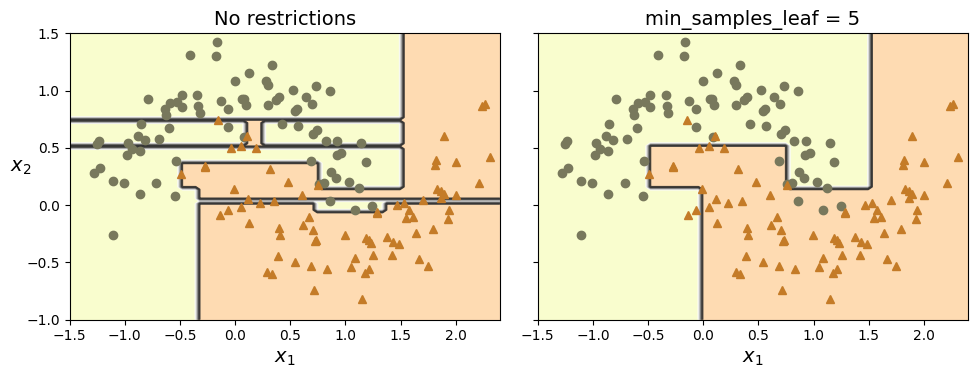

In [90]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
save_fig("min_samples_leaf_plot")
plt.show()

El modelo no regularizado de la izquierda está claramente sobreajustado, y el modelo regularizado de la derecha probablemente generalizará mejor. Podemos comprobarlo evaluando ambos árboles en un conjunto de pruebas generado con una semilla aleatoria diferente:


In [91]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [92]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

De hecho, el segundo árbol tiene una mayor precisión en el conjunto de pruebas.

# Regression

Los árboles de decisión también son capaces de realizar tareas de regresión. Construyamos un árbol de regresión utilizando la clase DecisionTreeRegressor de Scikit-Learn, entrenándolo en un conjunto de datos cuadráticos ruidosos con max_depth=2:


In [93]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5  # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

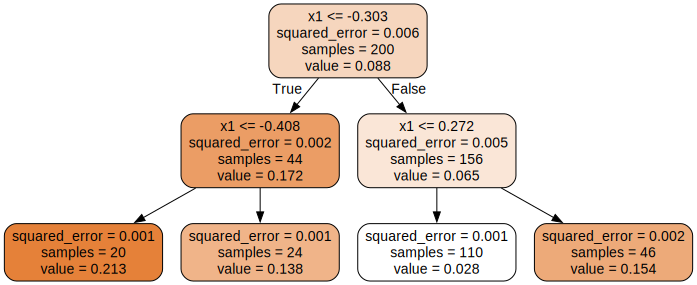

In [94]:
export_graphviz(
    tree_reg,
    out_file=str(IMAGES_PATH / "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

Este árbol tiene un aspecto muy similar al árbol de clasificación que construyó anteriormente. La principal diferencia es que en lugar de predecir una clase en cada nodo, predice un valor. Por ejemplo, supongamos que quiere hacer una predicción para una nueva instancia con $x_1 = 0.2$. El nodo raíz pregunta si $x_1 ≤ -0,303$. Si no lo es, el algoritmo pasa al nodo hijo derecho, que pregunta si $x_1 ≤ 0,272$. Si lo es, el algoritmo pasa al nodo hijo izquierdo. Éste es un nodo hoja, y predice $valor=0,028$. Esta predicción es el valor objetivo medio de las 110 instancias de entrenamiento asociadas a este nodo hoja, y da como resultado un error cuadrático medio igual a 0,0015 sobre estas 110 instancias

In [95]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [96]:
tree_reg.tree_.threshold

array([-0.30265072, -0.40830374, -2.        , -2.        ,  0.27175756,
       -2.        , -2.        ])

In [97]:
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

Las predicciones de este modelo se representan a la izquierda en la figura. Si establece max_depth=3, obtendrá las predicciones representadas a la derecha. Observe cómo el valor predicho para cada región es siempre el valor objetivo medio de las instancias de esa región. El algoritmo divide cada región de forma que la mayoría de las instancias de entrenamiento se acerquen lo máximo posible a ese valor predicho.

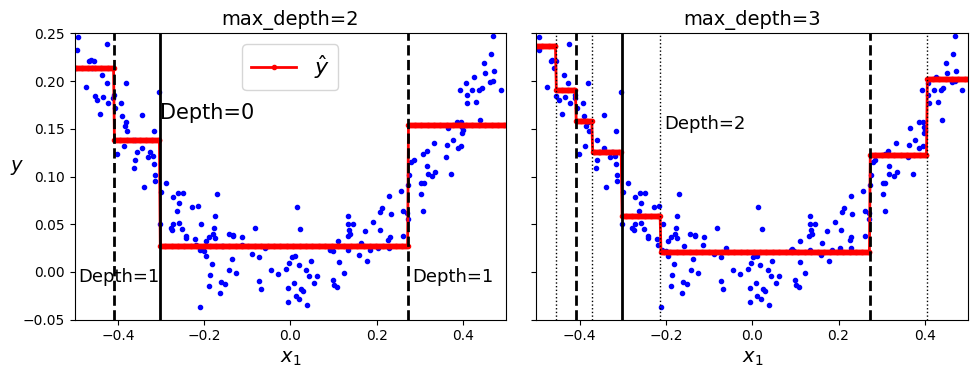

In [98]:

def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

save_fig("tree_regression_plot")
plt.show()

El algoritmo CART funciona como se ha descrito anteriormente, salvo que en lugar de intentar dividir el conjunto de entrenamiento de forma que se minimice la impureza, ahora intenta dividir el conjunto de entrenamiento de forma que se minimice el MSE. La ecuación muestra la función de coste que el algoritmo intenta minimizar.

$$
J(k, t_k) = \frac{m_{\text{left}}}{m} \text{MSE}_{\text{left}} + \frac{m_{\text{right}}}{m} \text{MSE}_{\text{right}}
$$
$$
\text{donde } \text{MSE}_{\text{node}} = \frac{\sum_{i} \in \text{node }(\hat{y}_{node} - y^{(i)})^2}{m_{\text{node}}}
$$
$$
\hat{y}_{\text{node}} = \frac{\sum_{i} \in \text{node }y^{(i)}}{m_{\text{node}}} $$


Al igual que en las tareas de clasificación, los árboles de decisión son propensos a sobreajustarse en las tareas de regresión. Sin ninguna regularización (es decir, utilizando los hiperparámetros por defecto), se obtienen las predicciones de la izquierda en la Figura. Obviamente, estas predicciones se ajustan en exceso al conjunto de entrenamiento. Con sólo establecer min_samples_leaf=10 se obtiene un modelo mucho más razonable, representado a la derecha en la Figura.

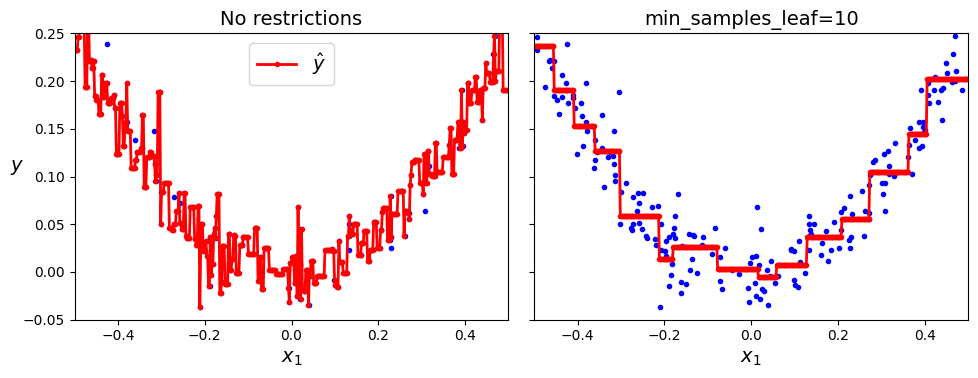

In [99]:

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

save_fig("tree_regression_regularization_plot")
plt.show()

# Sensitivity to axis orientation

Es de esperar que a estas alturas esté convencido de que los árboles de decisión tienen mucho a su favor: son relativamente fáciles de entender e interpretar, sencillos de utilizar, versátiles y potentes. Sin embargo, tienen algunas limitaciones. En primer lugar, como habrá observado, a los árboles de decisión les encantan los límites de decisión ortogonales (todas las divisiones son perpendiculares a un eje), lo que los hace sensibles a la orientación de los datos. Por ejemplo, la figura muestra un conjunto de datos sencillo y linealmente separable: a la izquierda, un árbol de decisión puede dividirlo fácilmente, mientras que a la derecha, después de girar el conjunto de datos 45°, el límite de decisión parece innecesariamente enrevesado. Aunque ambos árboles de decisión se ajustan perfectamente al conjunto de entrenamiento, es muy probable que el modelo de la derecha no generalice bien.

Al girar el conjunto de datos también se obtienen límites de decisión completamente distintos:

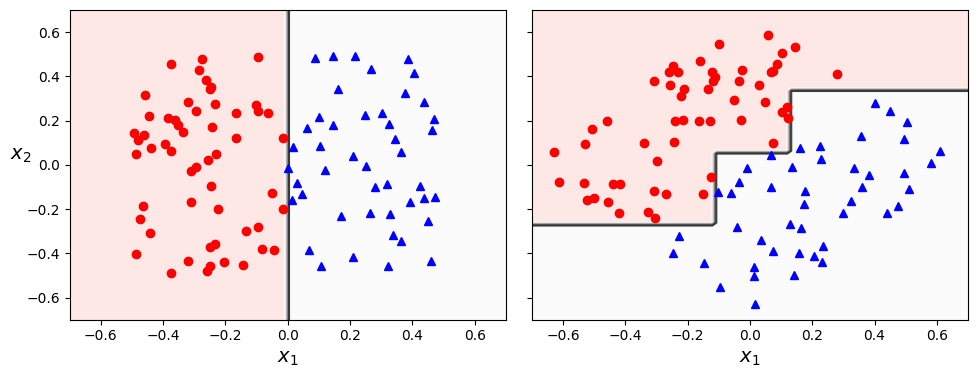

In [100]:

np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

Una forma de limitar este problema es escalar los datos y, a continuación, aplicar una transformación de análisis de componentes principales. Veremos el PCA en detalle en el Modelos No Supervisados, pero por ahora sólo necesita saber que rota los datos de una forma que reduce la correlación entre las características, lo que a menudo (no siempre) facilita las cosas para los árboles. Vamos a crear un pequeño pipeline que escale los datos y los rote usando PCA, y luego entrenar un DecisionTreeClassifier en esos datos. La figura muestra los límites de decisión de ese árbol: como se puede ver, la rotación permite ajustar el conjunto de datos bastante bien utilizando sólo una característica, $z_1$ , que es una función lineal de la longitud y anchura del pétalo original. Aquí está el código:

In [101]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

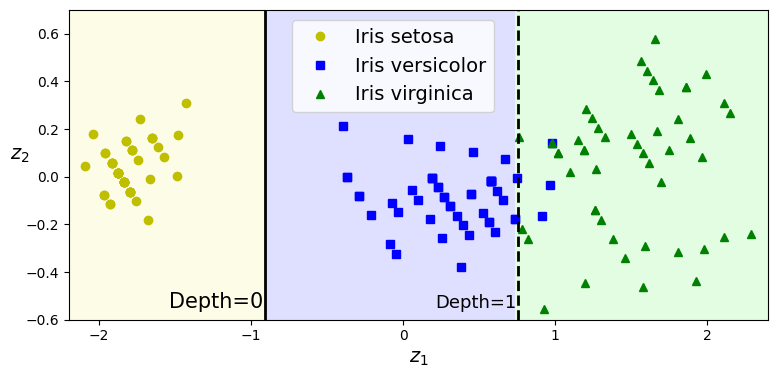

In [102]:
plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))
save_fig("pca_preprocessing_plot")

plt.show()

# Decision Trees Have High Variance

En términos más generales, el principal problema de los árboles de decisión es que tienen una varianza bastante alta: pequeños cambios en los hiperparámetros o en los datos pueden producir modelos muy diferentes. De hecho, dado que el algoritmo de entrenamiento utilizado por Scikit-Learn es estocástico -selecciona aleatoriamente el conjunto de características a evaluar en cada nodo-, incluso volver a entrenar el mismo árbol de decisión con exactamente los mismos datos puede producir un modelo muy diferente, como el representado en la Figura (a menos que configure el hiperparámetro random_state). Como puede ver, tiene un aspecto muy diferente del árbol de decisión anterior.

Hemos visto que pequeños cambios en el conjunto de datos (como una rotación) pueden producir un Árbol de Decisión muy diferente.

Ahora vamos a demostrar que entrenar el mismo modelo con los mismos datos puede producir un modelo muy diferente cada vez, ya que el algoritmo de entrenamiento CART utilizado por Scikit-Learn es estocástico. Para demostrarlo, estableceremos `estado_aleatorio` a un valor diferente del anterior:

In [103]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=40)

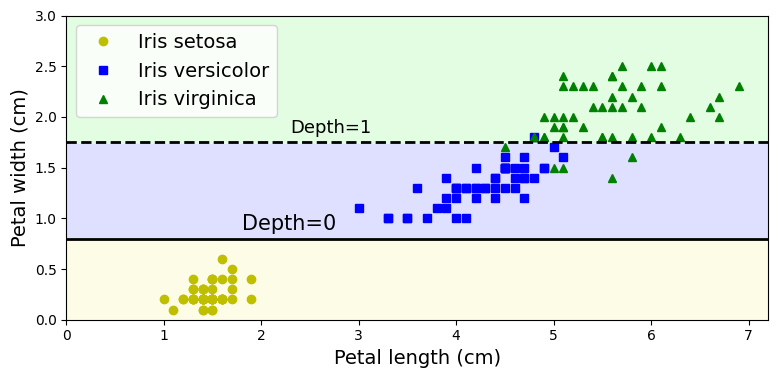

In [104]:

plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_high_variance_plot")

plt.show()

Por suerte, al promediar las predicciones de muchos árboles, es posible reducir la varianza de forma significativa. Este conjunto de árboles se denomina RandomForest y es uno de los tipos de modelos más potentes que existen en la actualidad.

# Material Extra - Accediendo a la estructura de árbol

Un `DecisionTreeClassifier` entrenado tiene un atributo `tree_` que almacena la estructura del árbol:

In [105]:
tree = tree_clf.tree_
tree

Puede obtener el número total de nodos del árbol:

In [106]:
tree.node_count

5

Y otros atributos autoexplicativos están disponibles:

In [107]:
tree.max_depth

2

In [108]:
tree.max_n_classes

3

In [109]:
tree.n_features

2

In [110]:
tree.n_outputs

1

In [111]:
tree.n_leaves

3

Toda la información sobre los nodos se almacena en matrices NumPy. Por ejemplo, la impureza de cada nodo:

In [112]:
tree.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

El nodo raíz está en el índice 0. Los nodos hijos izquierdo y derecho del nodo _i_ son `tree.children_left[i]` y `tree.children_right[i]`. Por ejemplo, los hijos del nodo raíz son:

In [113]:
tree.children_left[0], tree.children_right[0]

(1, 2)

Cuando los nodos izquierdo y derecho son iguales, significa que se trata de un nodo hoja (y los ids de los nodos hijos son arbitrarios):

In [114]:
tree.children_left[3], tree.children_right[3]

(-1, -1)

Así puedes obtener los ids de los nodos hoja de la siguiente manera:

In [115]:
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

Los nodos que no son hojas se denominan _nodos de división_. La característica que dividen está disponible a través de la matriz `feature`. Los valores de los nodos hoja deben ignorarse:

In [116]:
tree.feature

array([ 0, -2,  1, -2, -2], dtype=int64)

Y los umbrales correspondientes son:

In [117]:
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

Y también está disponible el número de instancias por clase que llegaron a cada nodo:

In [118]:
tree.value

array([[[0.33333333, 0.33333333, 0.33333333]],

       [[1.        , 0.        , 0.        ]],

       [[0.        , 0.5       , 0.5       ]],

       [[0.        , 0.90740741, 0.09259259]],

       [[0.        , 0.02173913, 0.97826087]]])

In [119]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [120]:
np.all(tree.value.sum(axis=(1, 2)) == tree.n_node_samples)

False

A continuación se explica cómo calcular la profundidad de cada nodo:

In [121]:
def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth

depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

He aquí cómo obtener los umbrales de todos los nodos divididos en la profundidad 1:

In [122]:
tree_clf.tree_.feature[(depth == 1) & (~is_leaf)]

array([1], dtype=int64)

In [123]:
tree_clf.tree_.threshold[(depth == 1) & (~is_leaf)]

array([1.75])